In [87]:
import pandas as pd
import numpy as np

# Dataset

In [88]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

# Getting to know the dataset

In [89]:
X, y = mnist['data'], mnist['target']
print('X shape:', X.shape)
print('Y shape:', y.shape)

X shape: (70000, 784)
Y shape: (70000,)


In [90]:
import matplotlib as mpl
import matplotlib.pyplot as plt

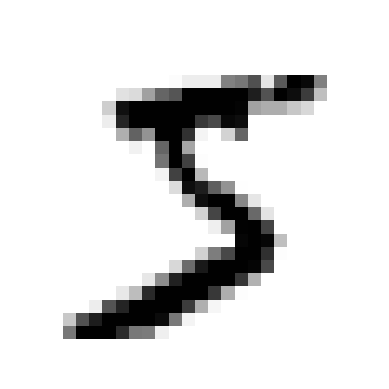

In [91]:
some_digit = X.iloc[0].values
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [92]:
y[0]

'5'

In [93]:
y = y.astype(np.uint8)

In [94]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a binary classifier

In [95]:
y_train_5 = (y_train == 5)

y_test_5 = (y_test == 5)

In [96]:
from sklearn.linear_model import SGDClassifier

In [97]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [98]:
sgd_clf.predict([some_digit])

/var/data/python/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## Accuracy

In [99]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)

    print(n_correct / len(y_pred))


0.9669
0.91625
0.96785


In [100]:
from sklearn.model_selection import cross_val_score

In [101]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [102]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [103]:
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

# Confusion matrix

In [104]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [105]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

53892 - True negative | 687 - False positive

1891 - False negative | 3530 - True positive

# Precision & Recall

In [106]:
from sklearn.metrics import precision_score, recall_score

In [107]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [108]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [109]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [110]:
y_score = sgd_clf.decision_function([some_digit])
y_score

/var/data/python/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [111]:
threshold = 8000
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

How to know which limit to use?

In [112]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [113]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [114]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.grid()
    plt.legend()

    plt.show()

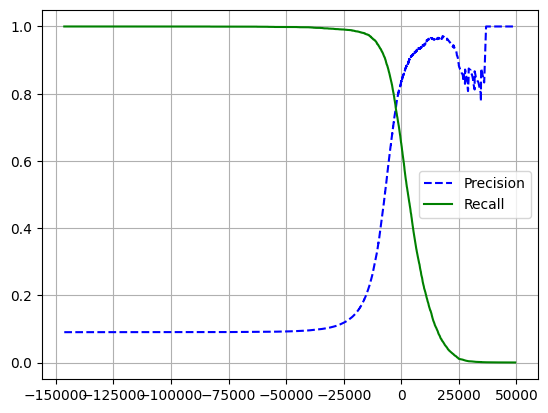

In [115]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


In [116]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [118]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [119]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [120]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

ROC Curve

In [121]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [127]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.grid(True)

    plt.show()

FPR = False Positive Rate

TPR = True Positive Rate

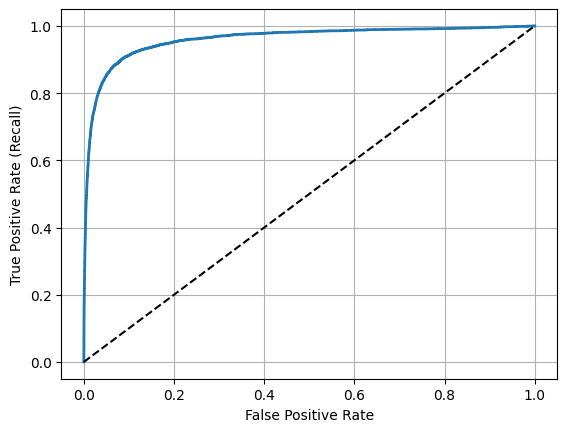

In [128]:
plot_roc_curve(fpr, tpr)

The furthest away from the black line (towards the top left corner), the better

In [131]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616